In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Symbolic Construction of Polynomial Chaos for Uniform Random Variables

Let $\Xi$ be a uniform random variable.
We are working in the Hilbert space:

$$
L^2(\Xi) = \left\{ f:[0,1]\mapsto \mathbb{R} \middle| \mathbb{E}\left[f^2(\Xi)\right] < +\infty \right\},
$$

equipped with the inner product:

$$
\langle f, g \rangle = \mathbb{E}\left[f(\Xi)g(\Xi)\right] = \int_0^1 f(\xi)g(\xi) \, d\xi.
$$

Notice that the square norm is just:

$$
\|f\|^2 = \langle f, f \rangle = \mathbb{E}\left[f^2(\Xi)\right] = \int_0^1 f^2(\xi) \, d\xi.
$$


We will use `sympy` to do symbolic computations.
We will take the linearly independent set of polynomials $\{1, \xi, \xi^2, \ldots, \xi^N\}$ and orthogonalize them with respect to the inner product above.
We will use the Gram-Schmidt process to do this.

Here we go:

In [24]:
import sympy
xi = sympy.symbols('xi')

# Our inner product symbolically:
inner_product = lambda f, g: sympy.integrate(f * g, (xi, 0, 1))
# Our norm:
norm = lambda f: sympy.sqrt(inner_product(f, f))

Let's do the first two examples by hand:

In [25]:
x1 = 1
e2 = x1 / norm(x1)
e1

1

Here is the second polynomial:

In [26]:
x2 = xi
v2 = x2 - inner_product(x2, e1) * e1
e2 = v2 / norm(v2)
e2

2*sqrt(3)*(xi - 1/2)

And here is code that makes the first ten:

In [27]:
num_terms = 10
es = [e1, e2]
xs = [xi ** i for i in range(10)]
for i in range(2, 10):
    x = xs[i]
    v = x
    for e in es:
        v -= inner_product(x, e) * e
    v /= norm(v)
    es.append(v)

Pretty print them:

In [29]:
from sympy import pprint

for i, e in enumerate(es):
    print(f"e{i+1}:")
    pprint(e)
    print()

e1:
1

e2:
2⋅√3⋅(ξ - 1/2)

e3:
     ⎛ 2       1⎞
6⋅√5⋅⎜ξ  - ξ + ─⎟
     ⎝         6⎠

e4:
      ⎛        2           ⎞
      ⎜ 3   3⋅ξ    3⋅ξ   1 ⎟
20⋅√7⋅⎜ξ  - ──── + ─── - ──⎟
      ⎝      2      5    20⎠

e5:
     4        3        2           
210⋅ξ  - 420⋅ξ  + 270⋅ξ  - 60⋅ξ + 3

e6:
        ⎛        4       3      2            ⎞
        ⎜ 5   5⋅ξ    20⋅ξ    5⋅ξ    5⋅ξ    1 ⎟
252⋅√11⋅⎜ξ  - ──── + ───── - ──── + ─── - ───⎟
        ⎝      2       9      6      42   252⎠

e7:
        ⎛                4       3      2           ⎞
        ⎜ 6      5   75⋅ξ    20⋅ξ    5⋅ξ    ξ     1 ⎟
924⋅√13⋅⎜ξ  - 3⋅ξ  + ───── - ───── + ──── - ── + ───⎟
        ⎝              22      11     11    22   924⎠

e8:
         ⎛        6       5        4        3       2             ⎞
         ⎜ 7   7⋅ξ    63⋅ξ    175⋅ξ    175⋅ξ    63⋅ξ    7⋅ξ    1  ⎟
3432⋅√15⋅⎜ξ  - ──── + ───── - ────── + ────── - ───── + ─── - ────⎟
         ⎝      2       13      52      143      286    429   3432⎠

e9:
          ⎛          

In applications, we do not usually normalize them, but just make the leading order coefficient one.

The polynomials we have constructed are similar to the Legendre polynomials, but not quite the same.
The Legendre polynomials are defined over the interval $[-1,1]$.

Let's plot them.
First, we need to turn them into `jax` functions:

In [34]:
from jax import vmap, jit
from functools import partial
import jax.numpy as jnp

@partial(jit, static_argnums=(1, 2))
@partial(vmap, in_axes=(0,))
def basis(xi, xi_sym=xi, es_sym=es):
    return jnp.array([
        sympy.lambdify(xi_sym, e, 'numpy')(xi)
        for e in es_sym
    ])

Isn't `jax` awesome?

Here, is how to use the code:

In [44]:
xis = jnp.linspace(0, 1, 500)
polys = basis(xis)
print(polys.shape)

(500, 10)


Let's plot them:

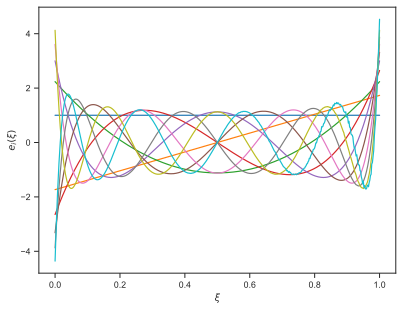

In [45]:
fig, ax = plt.subplots()
ax.plot(xis, polys)
ax.set(xlabel=r'$\xi$', ylabel=r'$e_i(\xi)$');

Notice that we get a little bit of numerical noise for the highest order.
There are more stable ways to calculate these polynomials.